In [1]:
import json

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')
from data import load_data
from utils.calibration import fit_temperature, calibrated_probas, normalize_probas, weights_from_logloss
from visualization import plot_classification_report, plot_f1_comparison_with_delta

from sklearn.preprocessing import LabelEncoder

In [2]:
_, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

idx = np.arange(len(y_val))

idx_meta, idx_eval = train_test_split(
    idx,
    test_size=0.30,
    random_state=42,
    stratify=y_val
)

In [3]:
# image

# Probabilités et logits sur la validation
logits_val_cn = np.load("../predictions/image/logits_convnext_val.npz")['logits']
logits_val_swin = np.load("../predictions/image/logits_swin_val.npz")['logits']
P_val_lr = np.load("../predictions/image/proba_cal_lr_val.npy")
logits_test_cn = np.load("../predictions/image/logits_convnext_test.npz")['logits']
logits_test_swin = np.load("../predictions/image/logits_swin_test.npz")['logits']
P_test_lr = np.load("../predictions/image/proba_cal_lr_test.npy")


# calibration des modèles
T_cn = fit_temperature(logits_val_cn, y_val)
T_swin = fit_temperature(logits_val_swin, y_val)
P_val_cn = calibrated_probas(logits_val_cn, T_cn)
P_val_swin = calibrated_probas(logits_val_swin, T_swin)
P_test_cn = calibrated_probas(logits_test_cn, T_cn)
P_test_swin = calibrated_probas(logits_test_swin, T_swin)

In [4]:
probas_img = {
    "convnext": P_val_cn,
    "swin": P_val_swin,
    "lr_image": P_val_lr,
}

configs_img = {
    "ConvNeXt + Swin": ["convnext", "swin"],
    "ConvNeXt + LR image": ["convnext", "lr_image"],
    "Swin + LR image": ["swin", "lr_image"],
    "ConvNeXt + Swin + LR image": ["convnext", "swin", "lr_image"],
}

rows = []

for config_name, models in configs_img.items():
    
    log_losses = {
        m: log_loss(y_val, probas_img[m])
        for m in models
    }

    weights = weights_from_logloss(log_losses)

    P_blend = sum(weights[m] * probas_img[m] for m in models)
    P_blend = normalize_probas(P_blend)

    y_pred = np.argmax(P_blend, axis=1)

    f1 = f1_score(
        y_val[idx_eval],
        y_pred[idx_eval],
        average="weighted"
    )

    ll = log_loss(
        y_val[idx_eval],
        P_blend[idx_eval]
    )

    rows.append({
        "configuration": config_name,
        "w_convnext": weights.get("convnext", 0.0),
        "w_swin": weights.get("swin", 0.0),
        "w_lr_image": weights.get("lr_image", 0.0),
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_blending_img = pd.DataFrame(rows).set_index("configuration")
df_blending_img.round(4)


,w_convnext,w_swin,w_lr_image,f1_weighted,log_loss
configuration,,,,,
ConvNeXt + Swin,0.5011,0.4989,0.0000,0.7630,0.8851
ConvNeXt + LR image,0.7094,0.0000,0.2906,0.7484,1.0379
Swin + LR image,0.0000,0.7085,0.2915,0.7490,1.0462
ConvNeXt + Swin + LR image,0.4158,0.4139,0.1703,0.7624,0.9341


In [5]:
rows = []

for config_name, models in configs_img.items():

    X_meta = np.concatenate([probas_img[m] for m in models], axis=1)

    X_meta_train = X_meta[idx_meta]
    X_meta_eval = X_meta[idx_eval]

    y_train = y_val[idx_meta]
    y_eval = y_val[idx_eval]

    meta_model = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
    )

    meta_model.fit(X_meta_train, y_train)

    P_eval = meta_model.predict_proba(X_meta_eval)
    P_eval = P_eval / P_eval.sum(axis=1, keepdims=True)

    y_pred = np.argmax(P_eval, axis=1)

    f1 = f1_score(
        y_eval,
        y_pred,
        average="weighted"
    )

    ll = log_loss(
        y_eval,
        P_eval
    )

    rows.append({
        "configuration": config_name,
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_stacking_img = pd.DataFrame(rows).set_index("configuration")

scores_img = pd.concat(
    [df_blending_img[["f1_weighted", "log_loss"]], df_stacking_img],
    axis=0
)

scores_img.index = [
    "blending - " + idx if i < len(df_blending_img)
    else "stacking - " + idx
    for i, idx in enumerate(scores_img.index)
]

scores_img


,f1_weighted,log_loss
blending - ConvNeXt + Swin,0.762965,0.885142
blending - ConvNeXt + LR image,0.748445,1.037881
blending - Swin + LR image,0.748978,1.046152
blending - ConvNeXt + Swin + LR image,0.762352,0.934053
stacking - ConvNeXt + Swin,0.763178,0.901284
stacking - ConvNeXt + LR image,0.750754,0.949527
stacking - Swin + LR image,0.748118,0.967770
stacking - ConvNeXt + Swin + LR image,0.763819,0.892041


### Choix final => blending blending - ConvNeXt + Swin (meilleur compromis logloss - f1 - facilité)


In [8]:
w_cn, w_swin = df_blending_img.iloc[0,:2]

P_val = w_cn * P_val_cn + w_swin * P_val_swin
P_test = w_cn * P_test_cn + w_swin * P_test_swin

np.save("../models/fusion/image/proba_image_val.npy", P_val)
np.save("../models/fusion/image/proba_image_test.npy", P_test)

pipeline_params = {
    "weights": {
        "convnext": float(w_cn),
        "swin": float(w_swin),
    },
    "calibration": {
        "T_convnext": float(T_cn),
        "T_swin": float(T_swin),
    }
}

with open("../models/fusion/image/pipeline_image_params.json", "w") as f:
    json.dump(pipeline_params, f, indent=2)

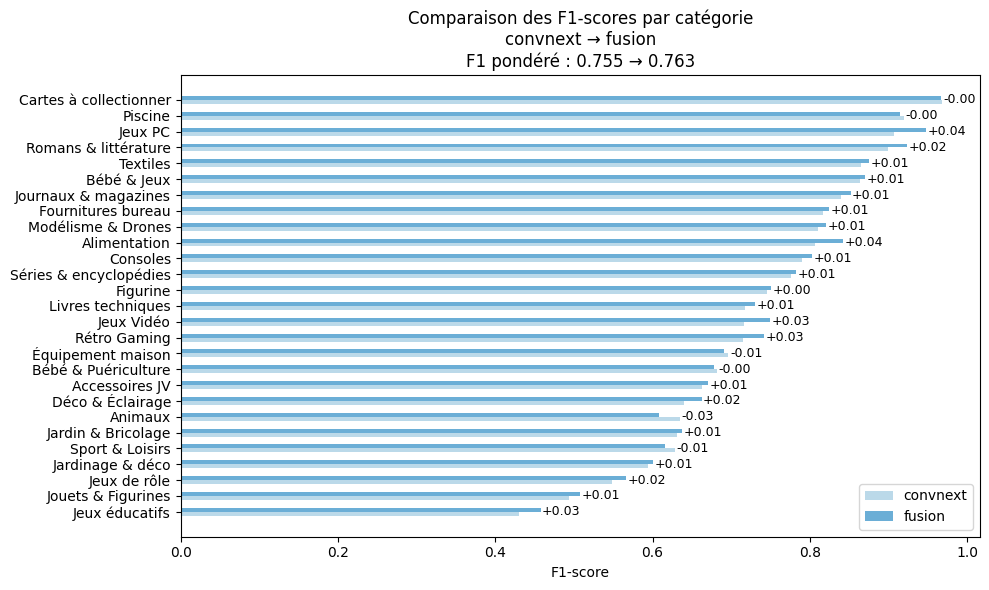

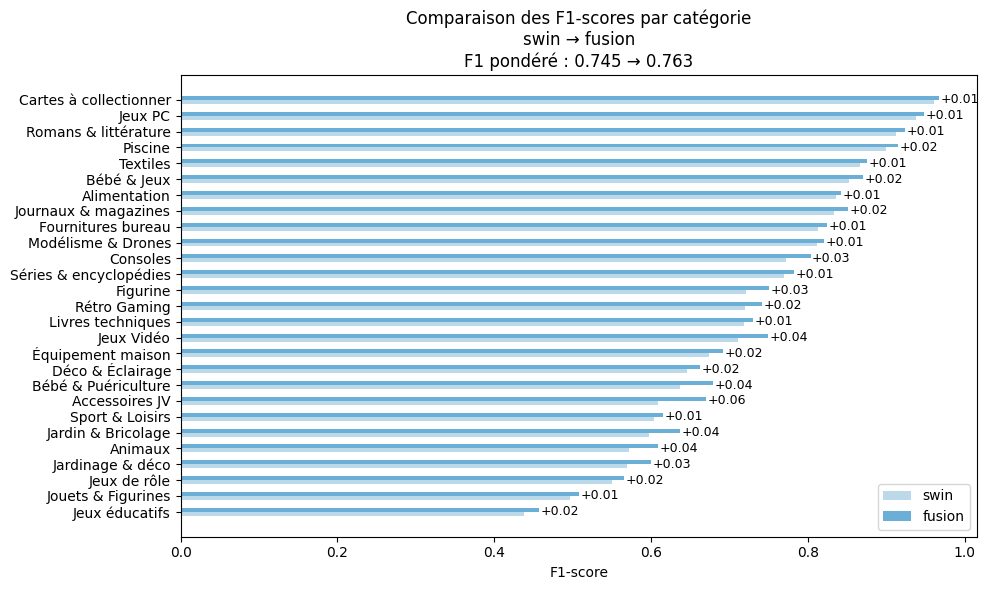

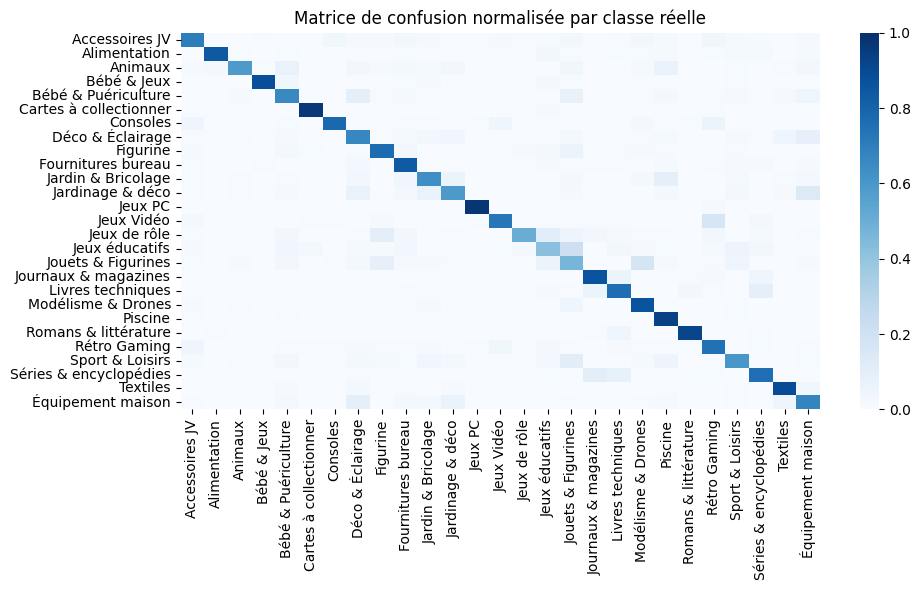


Classes avec les plus faibles scores F1 (bottom 5)


,precision,recall,f1-score,support
Animaux,0.629,0.589,0.608,124.0
Jardinage & déco,0.611,0.590,0.600,388.0
Jeux de rôle,0.644,0.504,0.566,115.0
Jouets & Figurines,0.550,0.472,0.508,731.0
Jeux éducatifs,0.496,0.424,0.458,311.0



Confusions les plus fréquentes (top 5)


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,21.9
1,Jouets & Figurines,Modélisme & Drones,17.1
2,Jeux Vidéo,Rétro Gaming,16.4
3,Jardinage & déco,Équipement maison,13.7
4,Jeux de rôle,Jeux éducatifs,11.3


In [7]:
y_pred = np.argmax(P_test, axis=1)
y_pred_cn = np.argmax(P_test_cn, axis=1)
y_pred_swin = np.argmax(P_test_swin, axis=1)

plot_f1_comparison_with_delta(y_test, y_pred, y_pred_cn, new_name="fusion", ref_name="convnext", encoder=encoder)
plot_f1_comparison_with_delta(y_test, y_pred, y_pred_swin, new_name="fusion", ref_name="swin", encoder=encoder)
plot_classification_report(y_test, y_pred, encoder=encoder)